# Binary Simplification in Metabolomics

Notebook to support the study on the application of **Bin**ary **Sim**plification as a competing form of pre-processing procedure for high-resolution metabolomics data.

This is notebook `paper_binsim.ipynb`


## Organization of the Notebook

- Set up database of data sets
- Application of different pre-treatments (including BinSim) to each data set
- Agglomerative Hierarchical Clustering and K-means Clustering: assessment of performence given a ground-truth of cluster assignments.


#### Needed Imports

In [1]:
import itertools

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

## Description of dataset records

`datasets` is the global dict that holds all data sets. It is a **dict of dict's**

Each data set is **represented as a dict**.

TO CONSIDER: migrate the table of datasets to a pandas DataFrame.

Each record has the following fields (keys):

- `name`: the table/figure name of the data set
- `source`: the biological source for each dataset
- `mode`: the aquisition mode
- `alignment`: the alignment used to generate the data matrix
- `data`: the data matrix
- `target`: the sample labels, possibly already integer encoded
- `<treatment name>`: transformed data matrix. These treatment names can be
    - `original`: an alias to `data`
    - `imputed`: missing value imputed data, only
    - `P`: Pareto scaled data
    - `NP`: Pareto scaled and normalized
    - `NGP`: normalized, glog transformed and Pareto scaled
    - `BinSim`: binary simplified data

The keys of `datasets` may be shared with dicts holding records resulting from comparison analysis.

Here are the keys used in this study:

- GD_neg_global2
- GD_pos_global2
- GD_neg_class2
- GD_pos_class2
- YD
- YD2
- vitis_types


#### correspondence to previously used names/variables in more focused notebooks

`aligned_all_pos` ↔ `datasets[GD_pos_global2]`

`aligned_all_neg` ↔ `datasets[GD_neg_global2]`

`aligned_all_pos2` ↔ `datasets[GD_pos_class2]`

`aligned_all_neg2` ↔ `datasets[GD_neg_class2]`

## Description of grapevine data sets

Grapevine Datasets (Negative and Positive) - 33 samples belonging to 11 different grapevine varieties (3 samples per variety/biological group).

5 different _Vitis_ species (other than _V. vinifera_) varieties:

- CAN - 3 Samples (14, 15, 16) of _V. candicans Engelmann_ (VIVC variety number: 13508)
- RIP - 3 Samples (17, 18, 19) of _V. riparia Michaux_ (Riparia Gloire de Montpellier, VIVC variety number: 4824) 
- ROT - 3 Samples (20, 21, 22) of _V. rotundifolia_ (Muscadinia Rotundifolia Michaux cv. Rotundifolia, VIVC variety number: 13586)
- RU - 3 Samples (35, 36, 37) of _V. rupestris Scheele_ (Rupestris du lot, VIVC variety number: 10389)
- LAB - 3 Samples (8, 9, 10) of _V. labrusca_ (Isabella, VIVC variety number: 5560)

6 different _V. vinifera_ cultivars varieties are:

- SYL - 3 samples (11, 12, 13) of the subspecies _sylvestris_ (VIVC variety number: -)
- CS - 3 Samples (29, 30, 31) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 1929)
- PN - 3 Samples (23, 24, 25) of the subspecies _sativa_ cultivar Pinot Noir (VIVC variety number: 9279)
- REG - 3 Samples (38, 39, 40) of the subspecies _sativa_ cultivar Regent (VIVC variety number: 4572)
- RL - 3 Samples (26, 27, 28) of the subspecies _sativa_ cultivar Riesling Weiss (VIVC variety number: 10077)
- TRI - 3 Samples (32, 33, 34) of the subspecies _sativa_ cultivar Cabernet Sauvignon (VIVC variety number: 15685)

Data acquired by Marisa et al. (2020):

Maia M, Ferreira AEN, Nascimento R, et al. Integrating metabolomics and targeted gene expression to uncover potential biomarkers of fungal / oomycetes ‑ associated disease susceptibility in grapevine. Sci Rep. Published online 2020:1-15. doi:10.1038/s41598-020-72781-2

**Peak Alignment** and **Peak Filtering** was performed with function `metabolinks.peak_alignment.align()`
(see `peak_alignments.ipynb` notebook)

**4** data matrices were constructed from this data:

- 1st Filtering/Alignment: Feature present in at least two samples in the dataset - min_sample = 2 considering all samples of the dataset. This alignment, "1-2", generated two datasets one for **positive mode** data acquisition and one for **negative mode** data acquisition. These data sets are names `GD_pos_global2` and `GD_neg_global2`, respectively.
- 2nd Filtering/Alignment: Feature present in at least two of the three samples of any biological group in the dataset. 
Each group is defined by the biological replicates of each Vitis species/cultivar. This alignment, "2-1", generated two datasets one for **positive mode** data acquisition and one for **negative mode** data acquisition. These data sets are names `GD_pos_class2` and `GD_neg_class2`, respectively.

For the purpose of assessing the performance of supervised methods each of these four datasets was used with target labels defining classes corresponding to replicates of each of the 11 Vitis species/cultivars.

For the purpose of assessing the performance of supervised methods under a binary (two-class) problem, data set `GD_neg_class2` was also used with target labels defining two classes: Vitis vinifera cultivars and "wild", non-vinifera Vitis species. This is dataset `vitis_types`.

## Description of the yeast data set

The Yeast dataset, data set `YD`, was acquired by J. Luz. The Yeast dataset consists of 15 samples of FT-ICR-MS metabolomics data obtained in positive ionization mode - 3 biological replicates of 5 different strains of Saccharomyces cerevisiae : the reference strain BY4741 (represented as BY) and 4 single-gene deletion mutants of this strain – ΔGLO1, ΔGLO2, ΔGRE3 and ΔENO1. These deleted genes are directly or indirectly related to methylglyoxal metabolism.

Peak Alignment and Peak Filtering was performed with MetaboScape 4.0 software (see dissertation for details in sample preparation, pre-processing, formula assignment). In short, the peak filtering made was made by keeping all features that appeared in at least 2 samples of the full dataset.

Yeast Dataset was obtained with Electrospray Ionization in Positive Mode, Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used ([M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da) and pre-processed by MetaboScape 4.0 (Bruker Daltonics) - see dissertation for details in pre-processing and formula assignment.

For the purpose of assessing the performance of supervised methods, this data set was used with target labels defining classes corresponding to replicates of each of the 4 yeast strains.

#### Loading yeast data set

In [3]:
def read_MetScape_file(filename,
                          col_renamer=None,
                          add_labels=None,
                          remove_ref_feat=None,):
    
    """Read in a MetaboScape bucket table from a CSV file."""
    
    data = pd.read_csv(filename).set_index('Bucket label')
    
    # optionally rename sample_names
    if col_renamer is not None:
        data = data.rename(columns=renamer)
    
    # optionally remove a reference feature (if already normalized)
    if remove_ref_feat is not None:
        #print(f'Feature {remove_ref_feat}\n{data.loc[remove_ref_feat, :]}\n----------')
        data = data.drop(index=[remove_ref_feat])
    
    # split in peak metadata and intensities
    peak_cols = ['m/z', 'Name', 'Formula']
    intensity_cols = [c for c in list(data.columns) if c not in peak_cols]
    peaks = data[peak_cols]
    intensities = data[intensity_cols]

    # replace zeros for NaN's
    intensities = intensities.replace(0, np.nan).dropna(how='all')
    
    # force peaks to have the same features as the (trimmed) intensities
    peaks = peaks.reindex(intensities.index)

    # optionally, add labels to intensities
    if add_labels is not None:
        intensities = mtl.add_labels(intensities, labels=add_labels)
    
    return {'filename': filename,
            'peaks':peaks,
            'intensities': intensities}

def renamer(colname):
    # Util to optionally remove all those 00000 from sample names
    return ''.join(colname.split('00000'))

In [4]:
# Labels of the 5 biological groups (5 yeast strains) - only added after
yeast_classes = 'WT ΔGRE3 ΔENO1 ΔGLO1 ΔGLO2'.split()

In [5]:
# Read in the file and keep results in dicts 

prefix_to_drop = None # change to 'ENO' to remove ENO strain

# MScape non-normalized dataset
MS_data = read_MetScape_file('5yeasts_notnorm.csv', 
                             remove_ref_feat=None,
                             add_labels=None,
                             col_renamer=renamer)

#MS_data

In [6]:
# keep features that appear in at least two samples
yeast_datamatrix = transf.keep_atleast(MS_data['intensities'].transpose(), minimum=2)
yeast_datamatrix

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,554.6687988435 Da,851.6819663479 Da,352.0866584613 Da,554.6387493588 Da,533.0467313042 Da,892.5313342202 Da,847.0028787316 Da,535.6351204857 Da,547.4252442854 Da,299.0852986149 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,557228.3750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,NaN,NaN,NaN,NaN,548196.50,NaN,NaN,NaN,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,540980.9375,NaN,543241.1875,NaN,NaN,NaN,551425.1250,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,562062.625,NaN,NaN,NaN,549861.4375,NaN,553295.750,545085.3750
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,NaN,NaN,540392.625,NaN,550756.625,NaN,NaN,NaN,NaN,545906.1875
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,NaN,NaN,NaN,558994.1250,548675.125,NaN,NaN,NaN,NaN,NaN


### Building data-sets data base

In [7]:
datasets = {}
# From the alignments_new store

data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg').transpose()
gd_labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '-',
                              'name': 'GDg2-',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}


data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_global2'] = {'source': 'grapevine',
                              'alignment': '1-2',
                              'mode': '+',
                              'name': 'GDg2+',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_neg_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '-',
                              'name': 'GDc2-',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_pos').transpose()
labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

datasets['GD_pos_class2'] = {'source': 'grapevine',
                              'alignment': '2-1',
                              'mode': '+',
                              'name': 'GDc2+',
                              'data': data_df,
                              'original': data_df,
                              'target': gd_labels,
                              'classes': list(pd.unique(gd_labels))}

yeast_labels = [item for item in yeast_classes for i in range(3)]

datasets['YD'] = {'source': 'yeast',
                            'alignment': '1-2',
                            'mode': '+',
                            'name': 'YD 2/15',
                            'data': yeast_datamatrix,
                            'original': yeast_datamatrix,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

min_non_na = '6/15'

yeast_datamatrix_less_na = transf.keep_atleast(yeast_datamatrix, minimum=eval(min_non_na))

datasets['YD2'] = {'source': 'yeast',
                            f'alignment': 'at_least {min_non_na}',
                            'mode': '+',
                            'name': 'YD ' + min_non_na,
                            'data': yeast_datamatrix_less_na,
                            'original': yeast_datamatrix_less_na,
                            'target': yeast_labels,
                            'classes': list(pd.unique(yeast_labels))}

vitis_types = {'CAN': 'wild', 'RIP': 'wild', 'ROT': 'wild','RU': 'wild', 'LAB': 'wild',
               'SYL': 'wild','REG': 'vinifera','CS': 'vinifera','PN': 'vinifera','RL': 'vinifera',
               'TRI': 'vinifera'}

gd_type_labels = [vitis_types[lbl] for lbl in gd_labels]

datasets['vitis_types'] = {'source': 'grapevine',
                            'alignment': '2-1',
                            'mode': '-',
                            'name': 'GD types',
                            'data': datasets['GD_neg_class2']['original'],
                            'original': datasets['GD_neg_class2']['original'],
                            'target': gd_type_labels,
                            'classes': list(pd.unique(gd_type_labels))}

print('target for grapevine 11-variety data sets')
print(datasets['GD_neg_global2']['target'])
print('------\ntarget for 4 yeast strains data set')
print(datasets['YD']['target'])
print('------\ntarget for 2-class wild Vitis vs Vitis vinifera data set')
print(datasets['vitis_types']['target'])

target for grapevine 11-variety data sets
['CAN', 'CAN', 'CAN', 'CS', 'CS', 'CS', 'LAB', 'LAB', 'LAB', 'PN', 'PN', 'PN', 'REG', 'REG', 'REG', 'RIP', 'RIP', 'RIP', 'RL', 'RL', 'RL', 'ROT', 'ROT', 'ROT', 'RU', 'RU', 'RU', 'SYL', 'SYL', 'SYL', 'TRI', 'TRI', 'TRI']
------
target for 4 yeast strains data set
['WT', 'WT', 'WT', 'ΔGRE3', 'ΔGRE3', 'ΔGRE3', 'ΔENO1', 'ΔENO1', 'ΔENO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO1', 'ΔGLO2', 'ΔGLO2', 'ΔGLO2']
------
target for 2-class wild Vitis vs Vitis vinifera data set
['wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera']


In [8]:
datasets['YD2']['data']

Bucket label,307.0838178877 Da,555.2692975341 Da,624.0873082632 Da,493.3168156897 Da,257.1028750516 Da,780.1092067055 Da,347.0630811124 Da,254.2246098628 Da,625.0869294704 Da,663.1091419334 Da,...,229.2123516866 Da,394.1157975983 Da,379.1049581299 Da,248.0382813898 Da,355.6157973903 Da,234.1618657562 Da,384.2188536141 Da,561.1740363894 Da,384.1550071491 Da,486.1583934820 Da
BY0_1,391042880.0,111270160.0,130088936.0,106187168.0,54234476.0,33863468.0,35209136.0,9935943.0,25313166.0,21631346.0,...,NaN,772182.5000,NaN,594449.9375,698648.0000,NaN,NaN,704317.1875,NaN,NaN
BY0_2,398003680.0,110423984.0,127133608.0,109233816.0,53720908.0,32622178.0,35636648.0,17679414.0,24989162.0,24420090.0,...,NaN,601594.2500,616405.1875,573408.3125,NaN,NaN,591270.6875,594117.8125,NaN,NaN
BY0_3,399481952.0,111225424.0,131208568.0,111553216.0,55826148.0,34655496.0,37943456.0,19530026.0,24684334.0,24862190.0,...,NaN,748387.5625,661618.0625,NaN,NaN,577509.4375,628977.9375,NaN,NaN,592246.8125
GRE3_1,270906400.0,92849040.0,130682664.0,104352720.0,46503348.0,33206608.0,32640452.0,5713388.5,25890872.0,28692028.0,...,NaN,670217.1250,NaN,582062.5000,NaN,NaN,NaN,NaN,561696.1875,NaN
GRE3_2,271023520.0,94888320.0,130844488.0,107277600.0,44828256.0,34597444.0,31696134.0,10139615.0,25548978.0,26964150.0,...,NaN,NaN,NaN,883340.5000,NaN,NaN,NaN,NaN,601161.2500,559238.4375
GRE3_3,274854272.0,94514272.0,130896568.0,109619152.0,46361588.0,33131336.0,31668180.0,16434200.0,25518902.0,26654308.0,...,562025.3125,NaN,NaN,556031.8125,NaN,NaN,NaN,NaN,681038.2500,558403.9375
ENO1_1,255276736.0,150620544.0,136612464.0,31276910.0,72465536.0,35298204.0,31236114.0,10759292.0,25798230.0,22221992.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,580237.7500,NaN,NaN
ENO1_2,251610656.0,148516304.0,134972800.0,31337604.0,70376640.0,35198252.0,30789652.0,25896608.0,26849502.0,23433602.0,...,NaN,NaN,NaN,NaN,NaN,657626.3125,NaN,NaN,NaN,NaN
ENO1_3,251024624.0,150645840.0,135922432.0,31644646.0,68912816.0,34380756.0,30916958.0,29723808.0,26606410.0,23500090.0,...,597902.5000,NaN,594469.9375,NaN,NaN,NaN,664188.5000,597523.3125,NaN,NaN
dGLO1_1,283822048.0,202869216.0,130259064.0,39904768.0,58269456.0,32095004.0,29669478.0,26538900.0,26013280.0,21245436.0,...,664256.5000,NaN,NaN,618080.8125,540651.7500,607250.8125,590962.6250,569196.3750,NaN,704541.7500


### Colors for plots to ensure consistency

#### 11- variety grapevine data sets

In [9]:
# customize label colors for 11 grapevine varieties

colours = sns.color_palette('Blues', 3)
colours.extend(sns.color_palette('Greens', 3))
#colours = sns.cubehelix_palette(n_colors=6, start=2, rot=0, dark=0.2, light=.9, reverse=True)
colours.extend(sns.color_palette('flare', 5))

ordered_vitis_labels = ('CAN','RIP','ROT','RU','LAB','SYL','REG','CS','PN','RL','TRI')

vitis_label_colors = {lbl: c for lbl, c in zip(ordered_vitis_labels, colours)}

tab20bcols = sns.color_palette('tab20b', 20)
tab20ccols = sns.color_palette('tab20c', 20)
tab20cols = sns.color_palette('tab20', 20)
tab10cols = sns.color_palette('tab10', 10)
dark2cols = sns.color_palette('Dark2', 8)

vitis_label_colors['RU'] = tab20bcols[8]
vitis_label_colors['CAN'] = tab20ccols[5]
vitis_label_colors['REG'] = tab10cols[3]

for name in datasets:
    if name.startswith('GD'):
        datasets[name]['label_colors'] = vitis_label_colors
        datasets[name]['sample_colors'] = [vitis_label_colors[lbl] for lbl in datasets[name]['target']]

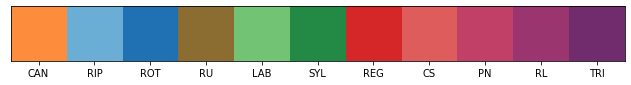

In [10]:
sns.palplot(vitis_label_colors.values())
new_ticks = plt.xticks(range(len(ordered_vitis_labels)), ordered_vitis_labels)

#### 5 yeast strains

In [11]:
# customize label colors for 5 yeast strains

colours = sns.color_palette('Set1', 5)
yeast_label_colors = {lbl: c for lbl, c in zip(yeast_classes, colours)}
datasets['YD']['label_colors'] = yeast_label_colors
datasets['YD']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD']['target']]
datasets['YD2']['label_colors'] = yeast_label_colors
datasets['YD2']['sample_colors'] = [yeast_label_colors[lbl] for lbl in datasets['YD2']['target']]

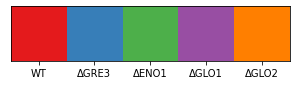

In [12]:
sns.palplot(yeast_label_colors.values())
new_ticks = plt.xticks(range(len(yeast_classes)), yeast_classes)

#### 2 classes of Vitis types

In [13]:
# customize label colors for 2 types of Vitis varieties

colours = [vitis_label_colors['SYL'], vitis_label_colors['TRI']]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

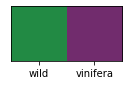

In [14]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

In [15]:
def styled_sample_labels(sample_names, sample_labels, label_colors):

    meta_table = pd.DataFrame({'label': sample_labels,
                               'sample': sample_names}).set_index('sample').T

    def apply_label_color(val):
        red, green, blue = label_colors[val]
        red, green, blue = int(red*255), int(green*255), int(blue*255)   
        hexcode = '#%02x%02x%02x' % (red, green, blue)
        css = f'background-color: {hexcode}'
        return css
    
    return meta_table.style.applymap(apply_label_color)

In [16]:
parsed = mtl.parse_data(datasets['GD_pos_class2']['data'], labels_loc='label')
y = datasets['GD_pos_class2']['target']
label_colors = datasets['GD_pos_class2']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,CAN,CAN,CAN,CS,CS,CS,LAB,LAB,LAB,PN,PN,PN,REG,REG,REG,RIP,RIP,RIP,RL,RL,RL,ROT,ROT,ROT,RU,RU,RU,SYL,SYL,SYL,TRI,TRI,TRI


In [17]:
parsed = mtl.parse_data(datasets['YD']['data'])
y = datasets['YD']['target']
label_colors = datasets['YD']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,BY0_1,BY0_2,BY0_3,GRE3_1,GRE3_2,GRE3_3,ENO1_1,ENO1_2,ENO1_3,dGLO1_1,dGLO1_2,dGLO1_3,GLO2_1,GLO2_2,GLO2_3
label,WT,WT,WT,ΔGRE3,ΔGRE3,ΔGRE3,ΔENO1,ΔENO1,ΔENO1,ΔGLO1,ΔGLO1,ΔGLO1,ΔGLO2,ΔGLO2,ΔGLO2


In [18]:
parsed = mtl.parse_data(datasets['vitis_types']['data'], labels_loc='label')
y = datasets['vitis_types']['target']
label_colors = datasets['vitis_types']['label_colors']
s = styled_sample_labels(parsed.sample_names, y, label_colors)
s

sample,14,15,16,29,30,31,8,9,10,23,24,25,38,39,40,17,18,19,26,27,28,20,21,22,35,36,37,11,12,13,32,33,34
label,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,vinifera,vinifera,vinifera,wild,wild,wild,vinifera,vinifera,vinifera,wild,wild,wild,wild,wild,wild,wild,wild,wild,vinifera,vinifera,vinifera


## Data transformations and pre-treatments

### Each Dataset is transformed to binary or treated by a combination of more established treatments


### Traditional Pre-Treatments

All samples need to have missing value imputation (removing features is optional). In this case, missing features were replaced with half of the minimum intensity of the full dataset.

This can be done with the `NaN_Imputation` function of scaling.py or `fillna_frac_min`(more options available) from metabolinks.

#### 3/4 types of combinations of traditional pre-treatments are made:

(Imp (Ionly) - Only Missing Value Imputation).

##### P Treatment - Missing Value Imputation and Pareto Scaling.

##### NP Treatment - Missing Value Imputation, Normalization by reference feature and Pareto Scaling.

##### NGP Treatment - Missing Value Imputation, Normalization by reference feature, Generalized Logarithmic Transformation and Pareto Scaling.

Note: Leucine Enkephalin peak is removed upon normalization.

### Binary Simplification (BinSim)

##### BinSim - `df_to_bool` function (very simple)

In [19]:
# Represents Binary Similarity pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)


def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data']
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP

Human leucine enkephalin (Sigma Aldrich) is the reference feature (internal standard) used for these datasets

[M+H]+ = 556.276575 Da or [M-H]- = 554.262022 Da

Search in the Negative GD and Positive GD for the reference feature with `search_for_ref_feat` (details in scaling.py).

### 1st Filtering/Alignment - 1-2 (used in dissertation)

#### Performing different combinations of pre-treatments for the Negative and Positive GD

Search for the reference feature.

In [20]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
# Theoretical mass for positive mode Leucine Enkephalin - 556.276575
Leu_Enk_neg = 554.262022
Leu_Enk_pos = 556.276575

# Reference Feature in the yeast dataset
leu_enk_name = '555.2692975341 Da'

In [21]:
query_datasets = [name for name in datasets if datasets[name]['source']=='grapevine']

for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...')
    ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable)
        delta = closest[ref_variable] - ref_variable
        print(f'In data: {closest[ref_variable]} delta = {delta:.3e}\n')

query_datasets = [name for name in datasets if name.startswith('YD')]

ref_variable = leu_enk_name
for name in query_datasets:
    ds = datasets[name]
    print(f'looking for reference in {name} ...') 
    closest = transf.find_closest_features(ds['data'], features=[ref_variable])
    if closest[ref_variable] is not None:
        print('Found ref feature', ref_variable, '\n')
    else:
        print('Ref feature not found\n')

looking for reference in GD_neg_global2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_global2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in GD_neg_class2 ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in GD_pos_class2 ...
Found ref feature 556.276575
In data: 556.27657 delta = -5.000e-06

looking for reference in vitis_types ...
Found ref feature 554.262022
In data: 554.26202 delta = -2.000e-06

looking for reference in YD ...
Found ref feature 555.2692975341 Da 

looking for reference in YD2 ...
Found ref feature 555.2692975341 Da 



Apply the different pre-treatments and get the results in their respective dictionaries

In [22]:
for name, ds in datasets.items():
    print(f'Applying pre-processing transformations to data in {name}', end=' ...')
    if name.startswith('YD'):
        ref_variable = leu_enk_name
    else:
        ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    
    compute_transf(ds, norm_ref=ref_variable)
    print('done!')

Applying pre-processing transformations to data in GD_neg_global2 ...done!
Applying pre-processing transformations to data in GD_pos_global2 ...done!
Applying pre-processing transformations to data in GD_neg_class2 ...done!
Applying pre-processing transformations to data in GD_pos_class2 ...done!
Applying pre-processing transformations to data in YD ...done!
Applying pre-processing transformations to data in YD2 ...done!
Applying pre-processing transformations to data in vitis_types ...done!


<span style="color:darkred;">------- Checkpoint for API migration</span>

In [23]:
# uncomment to generate checkpoint for old API
#treat_neg2['NGP'].to_csv('treat_neg2_NGP.csv', sep='\t')

roundrobin = pd.read_csv('treat_neg2_NGP.csv', sep='\t', header=[0,1], index_col=0)

# should not raise AssertionError:
assert_frame_equal(roundrobin, datasets['GD_neg_class2']['NGP'].transpose())


# A NOTE on pandas problem:
# assert_frame_equal(roundrobin.transpose(), treat_neg2['NGP'])
# fails the assertion because of m/z value float innacuracy when save to csv.

#roundrobin.transpose()

<span style="color:darkred;">------- END checkpoint for API migration</span>

## Dataset Characteristics

In [24]:
def characterize_dataset(dskey, ds):
#for dskey, ds in datasets.items():
    dataset_chrs = {}
    
    name = ds['name'] # Name of the dataset
    n_samples, n_feats = ds['data'].shape
    n_classes = len(ds['classes'])
       
    Feat_Sample = ds['data'].count(axis=1) # Nº Features in each sample
    Min_Feat_Sample = str(Feat_Sample.min())
    Max_Feat_Sample = str(Feat_Sample.max())
    Average_Feat_Sample = Feat_Sample.mean()
    
    avg_feat_per_sample = int(round(Average_Feat_Sample,0)) # Round
    
    Samp_Class = len(ds['target'])/len(ds['classes'])
    if dskey == 'vitis_types':
        Samp_Class = '15 Vitis vinifera, 18 Wild'
        #Samp_Class = '15 $\it{Vitis}$ $\it{Vinifera}$, 18 Wild'
    else:
        Samp_Class = str(int(Samp_Class))
    
    n_na = ds['data'].isna().sum().sum()
    
    p_na = round(100.0 * n_na / (n_samples * n_feats), 2)
    
    avg_na_per_feature = (n_samples - ds['data'].count(axis=0)).mean()
    avg_na_per_feature = int(round(avg_na_per_feature, 0))
    
    return {'Data set': name,
            '# samples': n_samples,
            '# features': n_feats,
            'features / sample (range)': f'{avg_feat_per_sample} ({Min_Feat_Sample}-{Max_Feat_Sample})',
            '# classes': n_classes,
            'samples / class':Samp_Class,
            '% missing values': p_na,} 
            #'missing values / feature': avg_na_per_feature}

data_characteristics = [characterize_dataset(dskey, ds) for dskey, ds in datasets.items()]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Data set')
data_characteristics

,# samples,# features,features / sample (range),# classes,samples / class,% missing values
Data set,,,,,,
GDg2-,33,3629,658 (367-1002),11,3,81.86
GDg2+,33,7026,1164 (355-2141),11,3,83.43
GDc2-,33,3026,547 (338-919),11,3,81.91
GDc2+,33,4565,824 (215-1670),11,3,81.94
YD 2/15,15,1973,685 (584-757),5,3,65.27
YD 6/15,15,606,468 (383-514),5,3,22.76
GD types,33,3026,547 (338-919),2,"15 Vitis vinifera, 18 Wild",81.91


In [25]:
data_characteristics.to_excel('paperimages/dataset_characteristics.xlsx', index=True)

In [26]:
def plot_PCA_old(principaldf, label_colors, label_symbols=None, components=(1,2), var_explained=None, title="PCA", ax=None):
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #with sns.axes_style("whitegrid"):
    ax.axis('equal')
    if var_explained is not None:
        v1, v2 = var_explained[loc_c1], var_explained[loc_c2]
        ax.set_xlabel(f'{col_c1_name} ({100*v1:.1f}%)', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name} ({100*v2:.1f}%)', fontsize = 15)
    else:
        ax.set_xlabel(f'{col_c1_name}', fontsize = 15)
        ax.set_ylabel(f'{col_c2_name}', fontsize = 15)

    unique_labels = principaldf['Label'].unique()
    if label_symbols is None:
        label_symbols = {lbl: 'o' for lbl in unique_labels}

    lbl_handles = {}
    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        hndl = ax.scatter(subset[col_c1_name], subset[col_c2_name],
                          lw=1,ec='black', alpha=0.8,
                          marker=label_symbols[lbl], 
                          s=80, color=label_colors[lbl], label=lbl)
        lbl_handles[lbl] = hndl

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)
    return lbl_handles

def plot_PCA(principaldf, label_colors, components=(1,2), title="PCA", ax=None):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    col_c1_name, col_c2_name = principaldf.columns[[loc_c1, loc_c2]]
    
    #ax.axis('equal')
    ax.set_xlabel(f'{col_c1_name}')
    ax.set_ylabel(f'{col_c2_name}')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset = principaldf[principaldf['Label']==lbl]
        ax.scatter(subset[col_c1_name],
                   subset[col_c2_name],
                   s=50, color=label_colors[lbl], label=lbl)

    #ax.legend(framealpha=1)
    ax.set_title(title, fontsize=15)

def plot_ellipses_PCA(principaldf, label_colors, components=(1,2),ax=None, q=None, nstd=2):
    "Plot the projection of samples in the 2 main components of a PLS-DA model."
    
    if ax is None:
        ax = plt.gca()
    
    loc_c1, loc_c2 = [c - 1 for c in components]
    points = principaldf.iloc[:, [loc_c1, loc_c2]]
    
    #ax.axis('equal')

    unique_labels = principaldf['Label'].unique()

    for lbl in unique_labels:
        subset_points = points[principaldf['Label']==lbl]
        plot_confidence_ellipse(subset_points, q, nstd, ax=ax, ec=label_colors[lbl], fc='none')


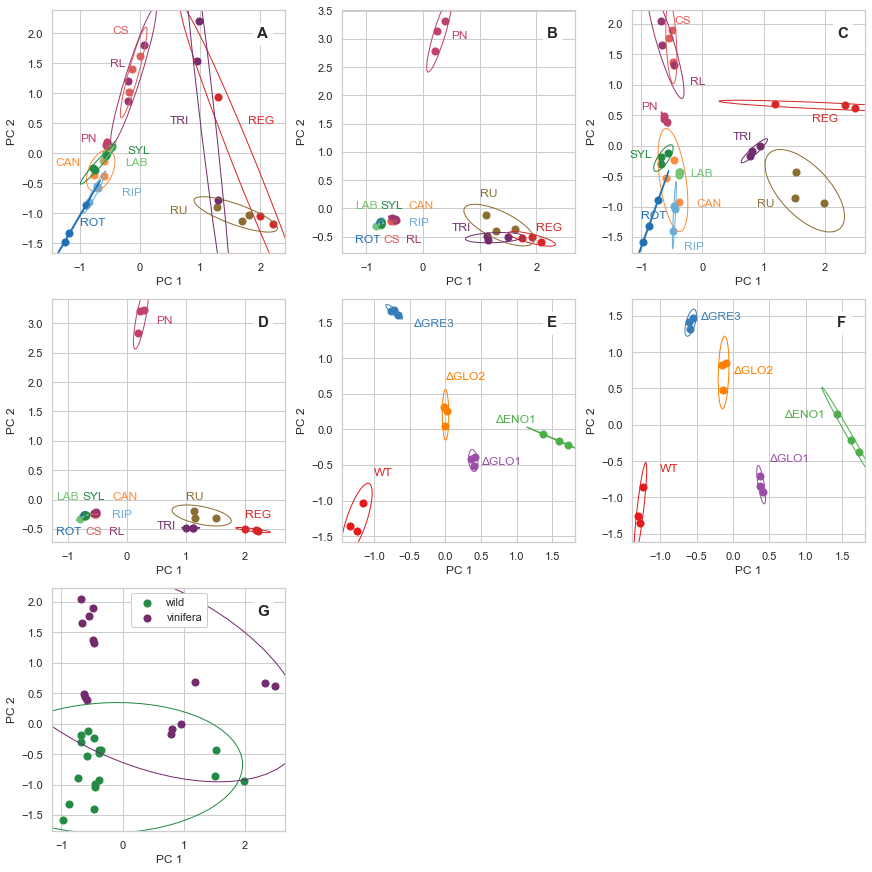

In [27]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, axs = plt.subplots(3,3, figsize=(12,12), constrained_layout=True)

        for (dskey, ds), ax in zip(datasets.items(), axs.ravel()):
            df = datasets[dskey]['Ionly']
            tf = transf.FeatureScaler(method='standard')
            df = tf.fit_transform(df)
            #print(df)
            ax.axis('equal')
            principaldf = ma.compute_df_with_PCs(df, n_components=5, whiten=True, labels=datasets[dskey]['target'], return_var_ratios=False)

            lcolors = datasets[dskey]['label_colors']
            #plot_PCA(principaldf, lcolors, components=(1,2), title=datasets[dskey]['name'], ax=ax)
            plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=ax)
            plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=ax, q=0.95)

        axs[2][1].remove()
        axs[2][2].remove()
        #axs[0][1].legend(loc='upper right', ncol=1)
        #axs[1][1].legend(loc='upper right', ncol=1)
        axs[2][0].legend(loc='upper center', ncol=1, framealpha=1)
        locs_YD = {'WT':(-1,-0.65),
                   'ΔGRE3':(-0.45, 1.45),
                   'ΔENO1':(0.7, 0.1),
                   'ΔGLO1':(0.5, -0.5),
                   'ΔGLO2':(0,0.7) }
        for lbl in datasets['YD']['classes']:
            axs[1][1].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])
        for lbl in datasets['YD']['classes']:
            axs[1][2].text(*locs_YD[lbl], lbl, c=datasets['YD']['label_colors'][lbl])

        locs_GD = {'CAN':(-1.4,-0.2),
                       'CS':(-0.45, 2),
                       'LAB':(-0.25, -0.2),
                       'PN':(-1, 0.2),
                       'REG':(1.8,0.5),
                       'RIP':(-0.3,-0.7),
                       'RL':(-0.5, 1.45),
                       'ROT':(-1, -1.2),
                       'RU':(0.5, -1),
                       'SYL':(-0.2,0),
                       'TRI':(0.5,0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.1,-1),
                       'CS':(-0.45, 2),
                       'LAB':(-0.2, -0.5),
                       'PN':(-1, 0.6),
                       'REG':(1.8,0.4),
                       'RIP':(-0.3,-1.7),
                       'RL':(-0.2, 1),
                       'ROT':(-1, -1.2),
                       'RU':(0.9, -1),
                       'SYL':(-1.2,-0.2),
                       'TRI':(0.5,0.1),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][2].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])

        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.3),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.5),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[1][0].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        locs_GD = {'CAN':(-0.25,0),
                       'CS':(-0.7, -0.6),
                       'LAB':(-1.2, 0),
                       'PN':(0.5, 3),
                       'REG':(2,-0.4),
                       'RIP':(-0.25,-0.3),
                       'RL':(-0.3, -0.6),
                       'ROT':(-1.2,-0.6),
                       'RU':(1, 0.2),
                       'SYL':(-0.75,0),
                       'TRI':(0.5,-0.4),}
        
        for lbl in datasets['GD_neg_global2']['classes']:
            axs[0][1].text(*locs_GD[lbl], lbl, c=datasets['GD_neg_global2']['label_colors'][lbl])
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()[0:7]):
            ax.text(0.88, 0.9, letter, ha='left', va='center', fontsize=15, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.9))
        
        plt.show()
        f.savefig('paperimages/PCAs.pdf', dpi=200)
        f.savefig('paperimages/PCAs.png', dpi=600)


### Graphical Representation of a portion of the GDc2- dataset after BinSim or NGP pre-treatments

Portion represented: From feature 51 to 150 from the GDc2- dataset.

In [28]:
# Needed extra import
from matplotlib import cm

# For the BinSim legend
Reds = cm.get_cmap('Reds', 20)
Present_Feature = mpatches.Patch(color=Reds(range(20))[-1], label='Present Feature (1)')
Absent_Feature = mpatches.Patch(color='white', label='Absent Feature (0)')

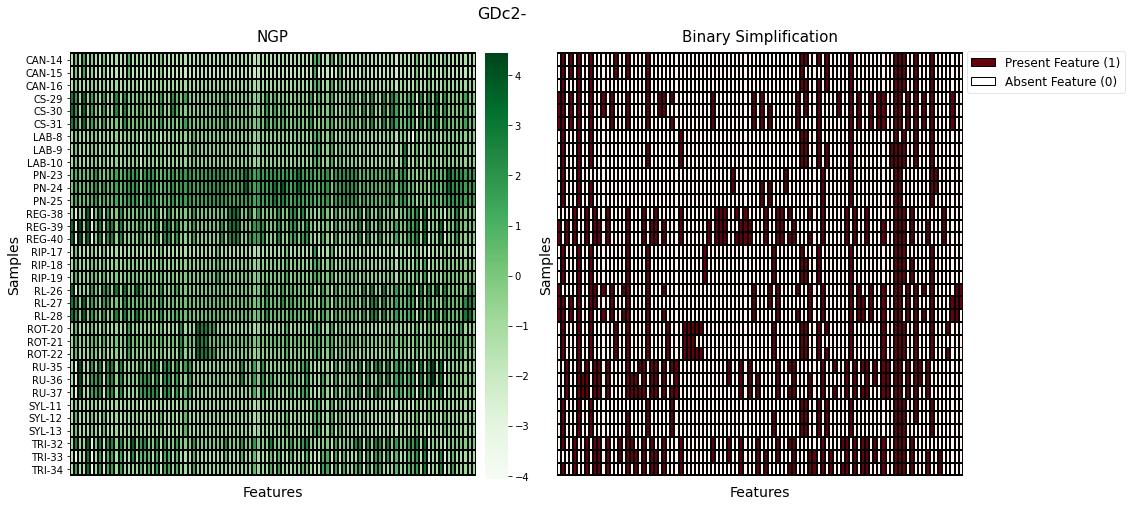

In [29]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(16,8))

cbar_ax = fig.add_axes([0.485, .13, .02, .74]) # For the colorbar

# NGP Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['NGP'].iloc[:,50:150], annot=False, ax=axl, cmap = 'Greens', linewidths = 1, 
                 linecolor = 'black',  xticklabels = False, cbar_ax=cbar_ax)#, norm=LogNorm())#cbar = False,
bottom, top = axl.get_ylim()

axl.set_ylim(bottom + 0.5, top - 0.5)
axl.set_title('NGP', fontsize=15)
axl.set_xlabel('Features', fontsize=14)
axl.set_ylabel('Samples', fontsize=14)

# BinSim Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['BinSim'].iloc[:,50:150], annot=False, ax=axr, cmap = 'Reds', linewidths = 1, 
                 linecolor = 'black', cbar = False, xticklabels = False, yticklabels = False)
bottom, top = axr.get_ylim()
axr.set_ylim(bottom + 0.5, top - 0.5)
axr.set_title('Binary Simplification', fontsize=15)
axr.set_xlabel('Features', fontsize=14)
axr.set_ylabel('Samples', fontsize=14)
axr.legend(handles = [Present_Feature, Absent_Feature], bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0., 
           fontsize = 12, ncol=1, frameon=True, framealpha=0.5, facecolor='white')
# Black box around legend colours
for legend_handle in axr.get_legend().legendHandles:
    legend_handle.set_edgecolor('black')
    
fig.suptitle('GDc2-', fontsize = 16, y=0.95)
plt.show()


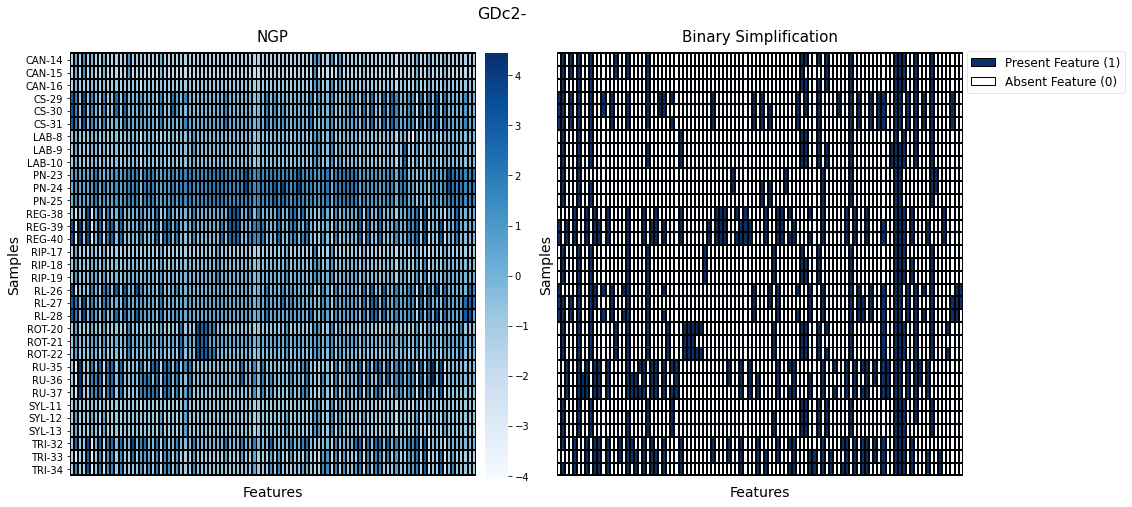

In [30]:
fig, (axl, axr) = plt.subplots(1,2, figsize=(16,8))

cbar_ax = fig.add_axes([0.485, .13, .02, .74]) # For the colorbar

# For the BinSim legend
Blues = cm.get_cmap('Blues', 20)
Present_Feature = mpatches.Patch(color=Blues(range(20))[-1], label='Present Feature (1)')
Absent_Feature = mpatches.Patch(color='white', label='Absent Feature (0)')

# NGP Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['NGP'].iloc[:,50:150], annot=False, ax=axl, cmap = 'Blues', linewidths = 1, 
                 linecolor = 'black',  xticklabels = False, cbar_ax=cbar_ax)#, norm=LogNorm())#cbar = False,
bottom, top = axl.get_ylim()

axl.set_ylim(bottom + 0.5, top - 0.5)
axl.set_title('NGP', fontsize=15)
axl.set_xlabel('Features', fontsize=14)
axl.set_ylabel('Samples', fontsize=14)

# BinSim Pre-Treatment
hm = sns.heatmap(datasets['GD_neg_class2']['BinSim'].iloc[:,50:150], annot=False, ax=axr, cmap = 'Blues', linewidths = 1, 
                 linecolor = 'black', cbar = False, xticklabels = False, yticklabels = False)
bottom, top = axr.get_ylim()
axr.set_ylim(bottom + 0.5, top - 0.5)
axr.set_title('Binary Simplification', fontsize=15)
axr.set_xlabel('Features', fontsize=14)
axr.set_ylabel('Samples', fontsize=14)
axr.legend(handles = [Present_Feature, Absent_Feature], bbox_to_anchor=(1.01, 0.99), loc='upper left', borderaxespad=0., 
           fontsize = 12, ncol=1, frameon=True, framealpha=0.5, facecolor='white')
# Black box around legend colours
for legend_handle in axr.get_legend().legendHandles:
    legend_handle.set_edgecolor('black')
    
fig.suptitle('GDc2-', fontsize = 16, y=0.95)
plt.show()


# Clustering methods

## Sample (Agglomerative) Hierarchical Cluster Analysis 

HCA analysis of each differently-treated dataset and corresponding dendrograms.

**Euclidian distance** and **UPGMA linkage** used for datasets obtained with traditional pre-treatments.

Several **binary distance** metrics (Jaccard as example) and **UPGMA linkage** for datasets obtained with BinSim.

In [31]:
def perform_HCA(df, metric='euclidean', method='average'):
    distances = dist.pdist(df, metric=metric)
    
    # method is one of
    #ward, average, centroid, single, complete, weighted, median
    Z = hier.linkage(distances, method=method)

    # Cophenetic Correlation Coefficient
    # (see how the clustering - from hier.linkage - preserves the original distances)
    coph = hier.cophenet(Z, distances)
    # Baker's gamma
    mr = ma.mergerank(Z)
    bg = mr[mr!=0]

    return {'Z': Z, 'distances': distances, 'coph': coph, 'merge_rank': mr, "Baker's Gamma": bg}

#### Computation of linkages, distances and cophenetics

- I - Missing Value Imputation only
- P - Imputed and Pareto scaled
- NP - Imputed, Normalized (reference feature) and Pareto scaled
- NGP - Imputed, Normalized (reference feature), glog transformed and Pareto scaled
- BinSim - Binary simplified data


Dictionaries to contain results

In [32]:
HCA_all = {}

Perform the clusterings

In [33]:
for name, ds in datasets.items():
    HCA_all[name] = {}
    for treat in 'P', 'NP', 'NGP', 'BinSim':
        print(f'Performing HCA to {name} data set with treatment {treat}', end=' ...')
        metric = 'jaccard' if treat == 'BinSim' else 'euclidean'
        HCA_all[name][treat] = perform_HCA(datasets[name][treat], metric=metric, method='average')
        print('done!')

Performing HCA to GD_neg_global2 data set with treatment P ...done!
Performing HCA to GD_neg_global2 data set with treatment NP ...done!
Performing HCA to GD_neg_global2 data set with treatment NGP ...done!
Performing HCA to GD_neg_global2 data set with treatment BinSim ...done!
Performing HCA to GD_pos_global2 data set with treatment P ...done!
Performing HCA to GD_pos_global2 data set with treatment NP ...done!
Performing HCA to GD_pos_global2 data set with treatment NGP ...done!
Performing HCA to GD_pos_global2 data set with treatment BinSim ...done!
Performing HCA to GD_neg_class2 data set with treatment P ...done!
Performing HCA to GD_neg_class2 data set with treatment NP ...done!
Performing HCA to GD_neg_class2 data set with treatment NGP ...done!
Performing HCA to GD_neg_class2 data set with treatment BinSim ...done!
Performing HCA to GD_pos_class2 data set with treatment P ...done!
Performing HCA to GD_pos_class2 data set with treatment NP ...done!
Performing HCA to GD_pos_clas

In [34]:
def plot_dendogram(Z, leaf_names, label_colors=None, title='', color_threshold=None):
    """Plot a dendrogram from a Z linkage matrix with a chosen title and a chosen color_threshold."""
    
    with plt.rc_context({'lines.linewidth':1.5}):

        fig, ax = plt.subplots(figsize=(10,6))
        dn = hier.dendrogram(Z, labels=leaf_names, leaf_font_size=13, above_threshold_color='b', leaf_rotation=45,
                             color_threshold=color_threshold)#,  orientation='left')

        ax.set_ylabel('Distance (UA)')
        ax.set_title(title, fontsize = 16)
        # Coloring labels
        if label_colors is not None:
            for lbl in ax.get_xmajorticklabels():
                lbl.set_color(label_colors[lbl.get_text()])

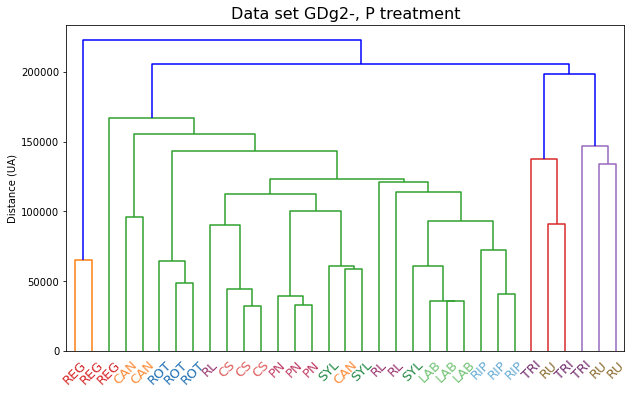

In [35]:
# GD, P for neg mode alignment 1-2

name = 'GD_neg_global2'
title = f"Data set {datasets[name]['name']}, P treatment"
plot_dendogram(HCA_all[name]['P']['Z'],
               datasets[name]['target'],
               label_colors=datasets[name]['label_colors'], title=title,
               color_threshold=175000)

In [36]:
# alternative dendogram plots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def color_list_to_matrix_and_cmap(colors, ind, axis=0):
        if any(issubclass(type(x), list) for x in colors):
            all_colors = set(itertools.chain(*colors))
            n = len(colors)
            m = len(colors[0])
        else:
            all_colors = set(colors)
            n = 1
            m = len(colors)
            colors = [colors]
        color_to_value = dict((col, i) for i, col in enumerate(all_colors))

        matrix = np.array([color_to_value[c]
                           for color in colors for c in color])

        matrix = matrix.reshape((n, m))
        matrix = matrix[:, ind]
        if axis == 0:
            # row-side:
            matrix = matrix.T

        cmap = mpl.colors.ListedColormap(all_colors)
        return matrix, cmap

def plot_dendogram2(Z, leaf_names, label_colors, title='', ax=None, no_labels=False, labelsize=12, **kwargs):
    if ax is None:
        ax = plt.gca()
    hier.dendrogram(Z, labels=leaf_names, leaf_font_size=10, above_threshold_color='0.2', orientation='left',
                    ax=ax, **kwargs)
    #Coloring labels
    #ax.set_ylabel('Distance (AU)')
    ax.set_xlabel('Distance (AU)')
    ax.set_title(title, fontsize = 15)
    
    #ax.tick_params(axis='x', which='major', pad=12)
    ax.tick_params(axis='y', which='major', labelsize=labelsize, pad=12)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #xlbls = ax.get_xmajorticklabels()
    xlbls = ax.get_ymajorticklabels()
    rectimage = []
    for lbl in xlbls:
        col = label_colors[lbl.get_text()]
        lbl.set_color(col)
        #lbl.set_fontweight('bold')
        if no_labels:
            lbl.set_color('w')
        rectimage.append(col)
    
    cols, cmap = color_list_to_matrix_and_cmap(rectimage, range(len(rectimage)), axis=0)

    axins = inset_axes(ax, width="5%", height="100%",
                   bbox_to_anchor=(1, 0, 1, 1),
                   bbox_transform=ax.transAxes, loc=3, borderpad=0)

    axins.pcolor(cols, cmap=cmap, edgecolors='w', linewidths=1)
    axins.axis('off')

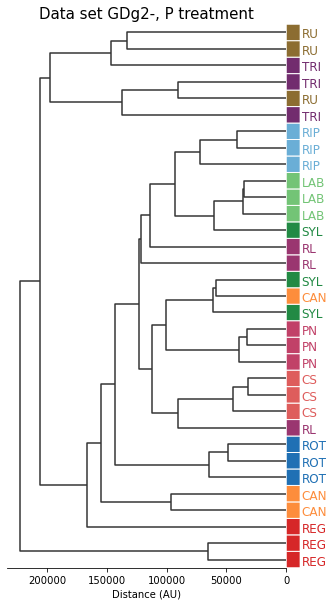

In [37]:
# P for neg mode alignment 1-2
f, ax = plt.subplots(figsize=(5, 10))
name = 'GD_neg_global2'
title = f"Data set {datasets[name]['name']}, P treatment"
plot_dendogram2(HCA_all[name]['P']['Z'], 
               datasets[name]['target'], ax=ax,
               label_colors=datasets[name]['label_colors'], title=title,
               color_threshold=0)

<span style="color:darkred;">------- Checkpoint for API migration</span>

In [38]:
Z = HCA_all['GD_neg_global2']['P']['Z']

col_names = 'cluster a', 'cluster b', 'd(a,b)', '# cluster a-b'
df_Z = pd.DataFrame(Z, index=range(1, len(Z)+1), columns=col_names)
df_Z.index.name = 'iteration'
df_Z.insert(2, 'new cluster', pd.Series(range(len(Z), 2*len(Z)+1)))

new_dtypes = {'cluster a': 'int64', 'cluster b': 'int64', '# cluster a-b': 'int64', 'new cluster': 'int64'}
df_Z = df_Z.astype(new_dtypes)

roundrobin = pd.read_csv('df_Z_P_neg.csv', sep='\t', index_col=0)

assert_frame_equal(roundrobin, df_Z)
#roundrobin

#df_Z

<span style="color:darkred;">------- END checkpoint for API migration</span>

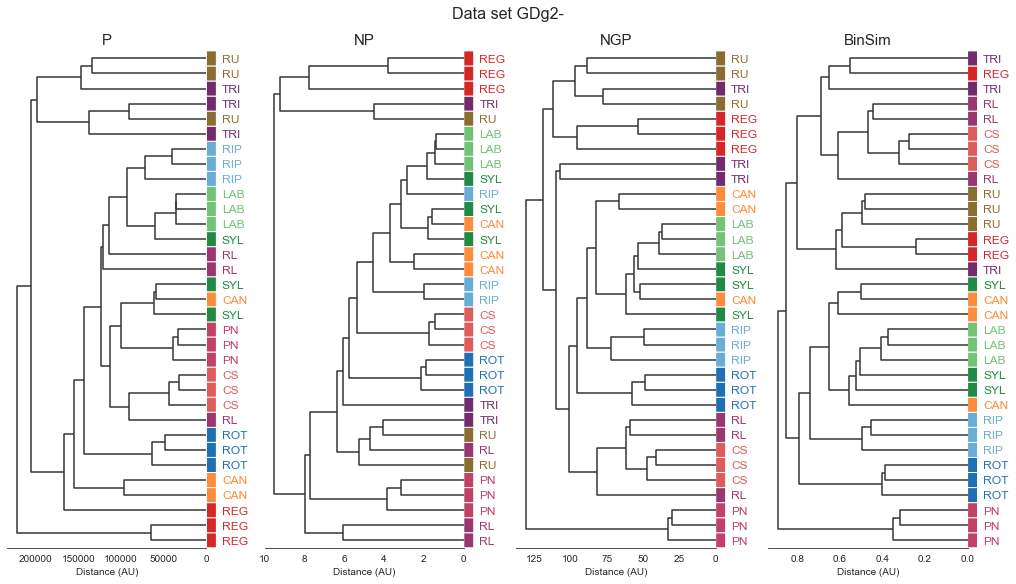

In [39]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_global2'
    
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

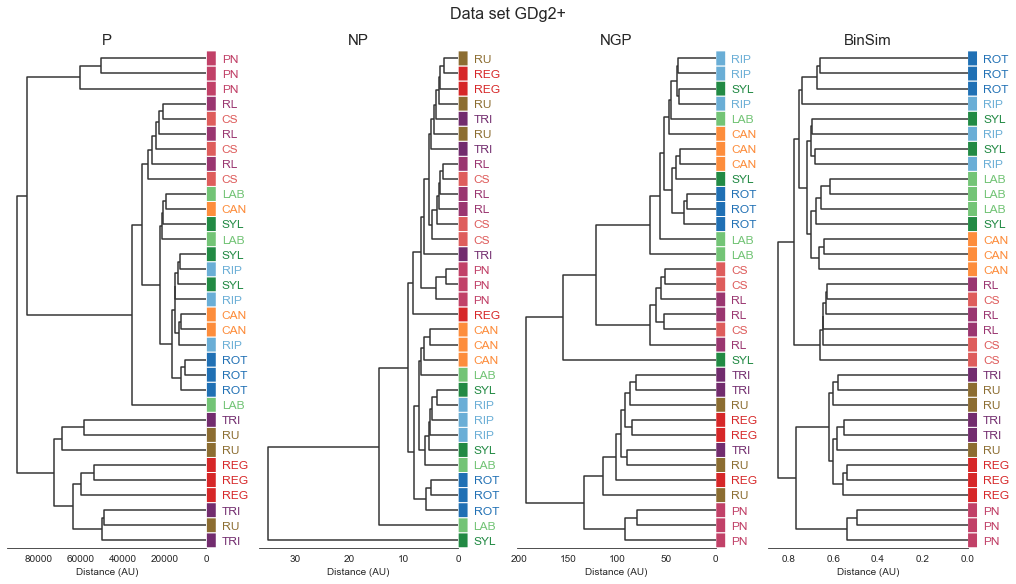

In [40]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_pos_global2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

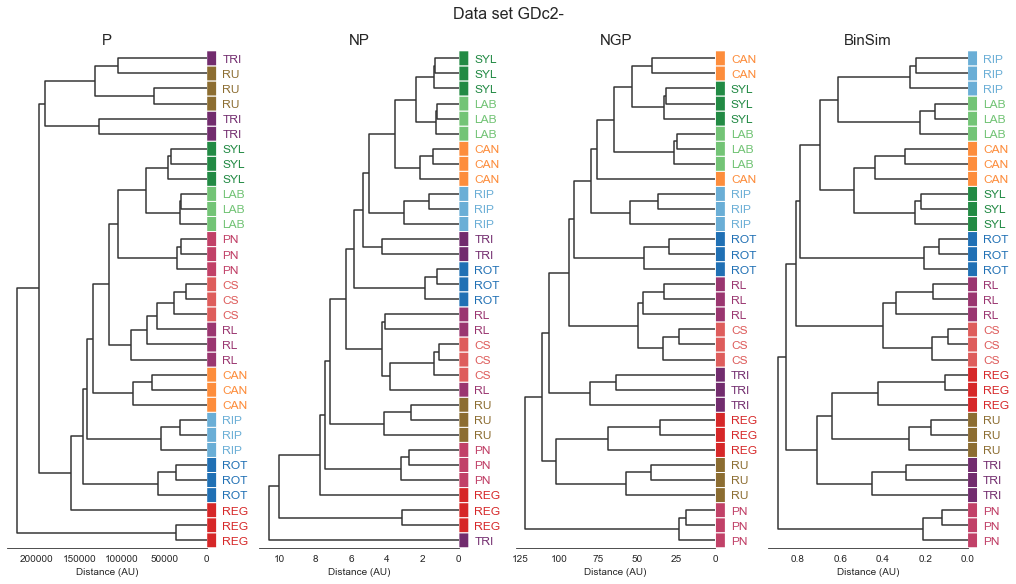

In [41]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_neg_class2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    plt.show()

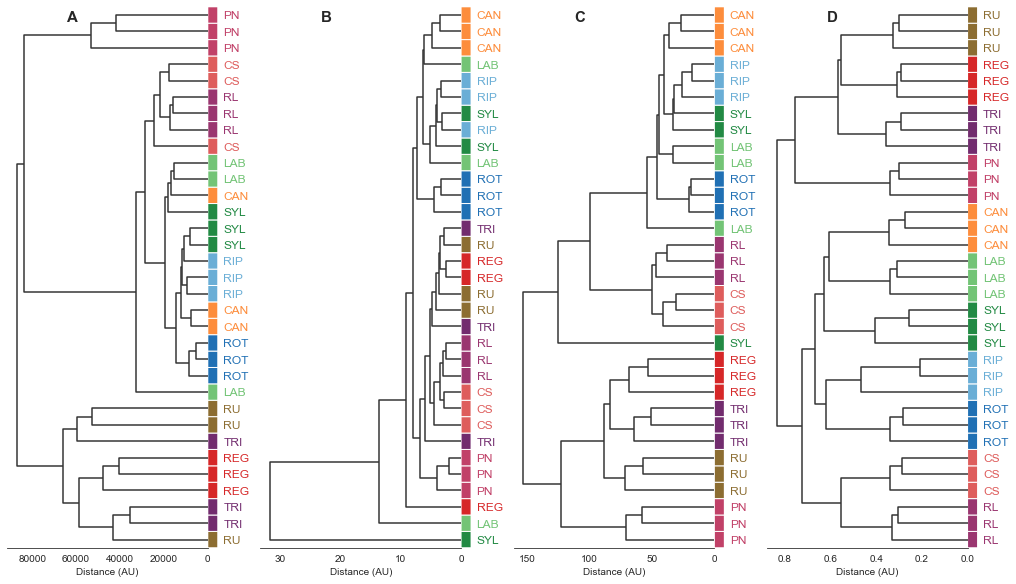

In [42]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(14, 8), constrained_layout=True)
    
    name = 'GD_pos_class2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title='', color_threshold=0)

    #st = f.suptitle(f"Data set {datasets[name]['name']}", fontsize=16)
    for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
        ax.text(0.3, 0.98, letter, ha='left', va='center', fontsize=15, weight='bold',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.9))

    plt.show()
    f.savefig('paperimages/dendrosGDpos21.pdf', dpi=200)
    f.savefig('paperimages/dendrosGDpos21.png', dpi=600)

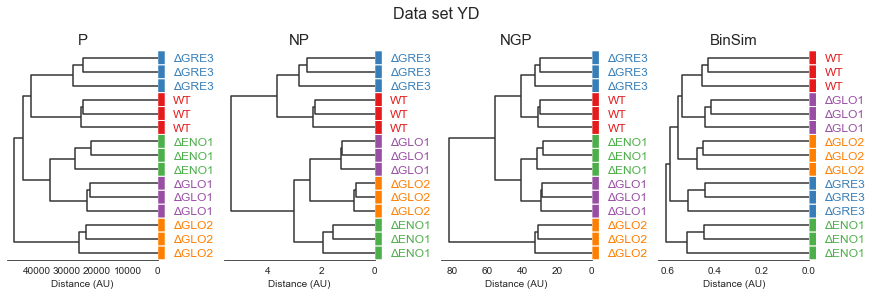

In [43]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle('Data set YD', fontsize=16)
    plt.show()

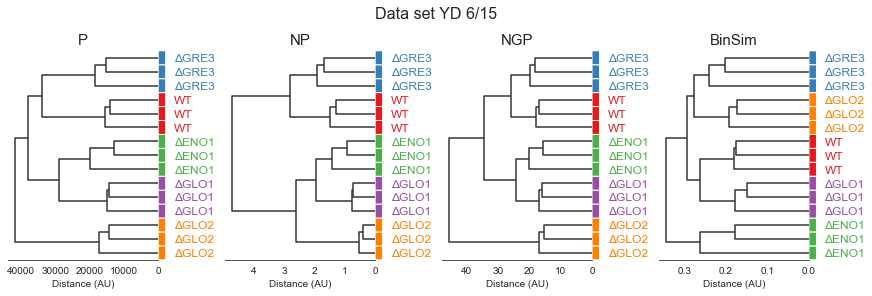

In [44]:
with sns.axes_style("white"):
    f, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
    
    name = 'YD2'
      
    for treatment, ax in zip(('P', 'NP', 'NGP', 'BinSim'), axs.ravel()):
        color_threshold = 0.68 if treatment == 'BinSim' else None
        plot_dendogram2(HCA_all[name][treatment]['Z'], 
                       datasets[name]['target'], ax=ax,
                       label_colors=datasets[name]['label_colors'],
                       title=treatment, color_threshold=0)

    st = f.suptitle(f'Data set {datasets[name]["name"]}', fontsize=16)
    plt.show()

### Similarity Comparison of the dendrograms made with all binary distance metrics and euclidean distances from the differently-treated datasets

#### Two methods: Cophenetic Correlation Coefficient and Baker's Gamma Correlation Coefficient

Baker's Gamma Correlation: Use of the `mergerank` function from multianalysis.py to create a 'rank' of the iteration number two samples were linked to the same cluster. Then see Kendall Correlation between the results from 2 dendrograms according to Baker's paper (Spearman Correlation according to R package 'dendextend').

Correlation Cophenetic Correlation: Pearson Correlation of the matrix of cophenetic distances of two different dendrograms.

### Traditionally-Treated Datasets - First Part (Until calculating correlations between dendrograms) of calculating the similarity coefficients

#### Examples of procedure with these methods with the Negative Grapevine Dataset (Alignment 1-2)

#### Cophenetic Correlation Coefficient

#### Baker's Gamma Correlation Coefficient (Kendall)

According to Original Paper (Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors)

(Spearman) According to the explanation given in the R package dendextend

In [45]:
pearsonr = stats.pearsonr
kendalltau = stats.kendalltau
spearmanr = stats.spearmanr

# checkpoint
#Pair of samples      	Pearson Correlation 	p-value
#P Treat-NP Treat	 0.6104807834038114 	 3.1088627739296713e-55
#P Treat-NGP Treat	 0.5804288742812359 	 7.10512725048972e-49


#Pair of samples      	Kendall Correlation 	p-value
#P Treat-NP Treat	 0.44330084075847676 	 2.817914814139397e-81
#P Treat-NGP Treat	 0.3507141621651369 	 2.271962729046075e-50

#Pair of samples      	Spearman Correlation 	p-value
#P Treat-NP Treat	 0.5684413829491447 	 2.0541620452455514e-91
#P Treat-NGP Treat	 0.4340345405568081 	 9.513613111794717e-50

table = []
t1 = HCA_all['GD_neg_global2']['P']
t2 = HCA_all['GD_neg_global2']['NP']
t3 = HCA_all['GD_neg_global2']['NGP']

r, p_value = pearsonr(t1['coph'][1], t2['coph'][1])
k, p_value_k = kendalltau(t1["Baker's Gamma"], t2["Baker's Gamma"])
s, p_value_s = spearmanr(t1["Baker's Gamma"], t2["Baker's Gamma"])
table.append({'Pair of samples': 'P Treat-NP Treat',
              'Cophenetic (Pearson)': r,
              '(coph) p-value': p_value,
              "Baker's (Kendall)":k,
              '(B-K) p-value': p_value_k,
              "Baker's (Spearman)":s,
              '(B-S) p-value': p_value_s,})

r, p_value = pearsonr(t1['coph'][1], t3['coph'][1])
k, p_value_k = kendalltau(t1["Baker's Gamma"], t3["Baker's Gamma"])
s, p_value_s = spearmanr(t1["Baker's Gamma"], t3["Baker's Gamma"])
table.append({'Pair of samples': 'P Treat-NGP Treat',
              'Cophenetic (Pearson)': r,
              '(coph) p-value': p_value,
              "Baker's (Kendall)":k,
              '(B-K) p-value': p_value_k,
              "Baker's (Spearman)":s,
              '(B-S) p-value': p_value_s,})

pd.DataFrame(table).set_index('Pair of samples')

,Cophenetic (Pearson),(coph) p-value,Baker's (Kendall),(B-K) p-value,Baker's (Spearman),(B-S) p-value
Pair of samples,,,,,,
P Treat-NP Treat,0.610481,3.108863e-55,0.443301,2.817915e-81,0.568441,2.054162e-91
P Treat-NGP Treat,0.580429,7.105127e-49,0.350714,2.271963e-50,0.434035,9.513613e-50


### BinSim-Treated Datasets: behaviour of different binary similarity measures in HCA
#### Part 1 (Perform HCAs)

**Note**: Applied to 1-2 alignment only, Negative and Positive modes

In [46]:
# 9 binary distance metrics accepted in pdist (scipy.spatial.distances.pdist)
binary_metrics = ('dice', 'hamming', 'jaccard', 'rogerstanimoto',
                  'sokalmichener', 'sokalsneath', 'yule', 'kulsinski',
                  'russellrao')
# 3 metrics that will be used as representative of the others
#(others not present have similar variations to one of those 3)
#binary = ( 'jaccard', 'hamming', 'yule')

In [47]:
# complement with HCA based on other binary distances using the BinSim treatment matrices

ds2use = 'GD_neg_global2', 'GD_pos_global2'

for name in ds2use:
    for bin_metric in binary_metrics:
        print(f'Performing HCA to {name} BinSim data set with metric {bin_metric}', end=' ...')
        HCA_all[name][bin_metric] = perform_HCA(datasets[name]['BinSim'], metric=bin_metric, method='average')
        print('done!')

Performing HCA to GD_neg_global2 BinSim data set with metric dice ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric hamming ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric jaccard ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric rogerstanimoto ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric sokalmichener ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric sokalsneath ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric yule ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric kulsinski ...done!
Performing HCA to GD_neg_global2 BinSim data set with metric russellrao ...done!
Performing HCA to GD_pos_global2 BinSim data set with metric dice ...done!
Performing HCA to GD_pos_global2 BinSim data set with metric hamming ...done!
Performing HCA to GD_pos_global2 BinSim data set with metric jaccard ...done!
Performing HCA to GD_pos_global2 BinSim data set wi

### Calculating the correlation between the dendrograms - Last step, calculate each pairwise correlation

Choose what set of linkage matrices (one for each differently-treated dataset) to consider when calculating similarity between them.

Here, we will show two sets of heatmaps that mimic the figures presented in the dissertation (that is, we will only show results for the 1st alignment/filtering - 1-2 - and with only 3 different binary distance metrics.

As for the Baker's Gamma Correlation, the heatmaps presented will be the ones with corellation calculated with Kendall correlation (according to the original paper - Baker FB. Stability of Two Hierarchical Grouping Techniques Case 1: Sensitivity to Data Errors. J Am Stat Assoc. 1974;69(346):440-445. doi:10.2307/2285675).

Although, seeing the other correlations is just a case of changing the 'S's and 'Coph's considered (next cell). 

Then, we will show one heatmap (cophenetic correlation coefficient) with 9 distance metrics for the 1st alignment.

### GDg2 with 3 different binary distance metrics

In [48]:
# Column names and row names for the dataframes and heatmaps
# Collect results of HCAs

colnames = ['P', 'NP', 'NGP','J' , 'H', 'Y']
treatments = ['P', 'NP', 'NGP','jaccard' , 'hamming', 'yule']

# Calculation of correlation coefficient by each method

def create_HCA_correlations(HCA_results, treatments, colnames):
    n_res = len(colnames)
    correlations = {key: np.empty((n_res, n_res)) for key in ('K', 'S', 'C', 'K_p', 'S_p', 'C_p')}

    for i, treat1 in enumerate(treatments):
        for j, treat2 in enumerate(treatments):
            Si, Sj = HCA_results[treat1], HCA_results[treat2]
            # K - Kendall (Baker's Gamma)
            k, p_value_k = stats.kendalltau(Si["Baker's Gamma"], Sj["Baker's Gamma"])
            correlations['K'][i,j], correlations['K_p'][i,j] = k, p_value_k

            # S - Spearman (Baker's Gamma)
            s, p_value_s = stats.spearmanr(Si["Baker's Gamma"], Sj["Baker's Gamma"])
            correlations['S'][i,j], correlations['S_p'][i,j] = s, p_value_s

            # C - Cophenetic Correlation
            r, p_value = stats.pearsonr(Si['coph'][1], Sj['coph'][1])
            correlations['C'][i,j], correlations['C_p'][i,j] = r, p_value

    for k in correlations:
        correlations[k] = pd.DataFrame(correlations[k], columns=colnames, index=colnames)
    return correlations

correlations_neg = create_HCA_correlations(HCA_all['GD_neg_global2'], treatments, colnames)
correlations_pos = create_HCA_correlations(HCA_all['GD_pos_global2'], treatments, colnames)

#### Heatmaps of the correlation coeficients for the 2 metrics

In [49]:
def relative_luminance(color):
    """Calculate the relative luminance of a color according to W3C standards
    Parameters
    ----------
    color : matplotlib color or sequence of matplotlib colors
        Hex code, rgb-tuple, or html color name.
    Returns
    -------
    luminance : float(s) between 0 and 1
    """
    rgb = mpl.colors.to_rgba_array(color)[:, :3]
    rgb = np.where(rgb <= .03928, rgb / 12.92, ((rgb + .055) / 1.055) ** 2.4)
    lum = rgb.dot([.2126, .7152, .0722])
    try:
        return lum.item()
    except ValueError:
        return lum

def plot_partitioned_df_asheatmap(df, ax=None, cmap='viridis', vmin=None, vmax=None, norm=None,
                                  partition_point=0, top_rotate=False, fontsize=14, colorbar=True):
    
    if ax is None:
        ax = plt.gca()
    
    values = df.values.copy()
    #values = np.flipud(values)
    # handle partition point
    
    # insert NaN column/row in values
    values = np.insert(values, partition_point, np.nan, axis=1)
    #values = np.insert(values, df.shape[0]- partition_point, np.nan, axis=0)
    values = np.insert(values, partition_point, np.nan, axis=0)
    
    # compute and insert 2% offset
    X = np.array(range(values.shape[0] + 1), dtype=float)
    Y = np.array(range(values.shape[1] + 1), dtype=float)
    offset = X[-1] * 0.02
    
    X[(partition_point+1):] = np.arange(float(partition_point)+offset, float(len(X)-1), 1.0)
    Y[(partition_point+1):] = np.arange(float(partition_point)+offset, float(len(Y)-1), 1.0)
    #Y[(len(Y)-partition_point-1):] = np.arange(float(len(Y)-partition_point-2)+offset, float(len(Y)-1), 1.0)

    # draw pcolormesh
    pm = ax.pcolormesh(X, Y, values, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    ax.set_ylim(ax.get_ylim()[1], ax.get_ylim()[0])
    ax.set_aspect('equal')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # handle labels
    midpoints_x = (X[1:] - X[:-1]) / 2 + X[:-1]
    midpoints_x = np.delete(midpoints_x, partition_point)
    midpoints_y = (Y[1:] - Y[:-1]) / 2 + Y[:-1]
    midpoints_y = np.delete(midpoints_y, partition_point)
    ax.set_xticks(midpoints_x)
    ax.set_yticks(midpoints_y)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    ax.tick_params(labeltop=True, labelbottom=False, labelsize=fontsize,
                   top=False, bottom=False, left=False, right=False)
    if top_rotate:
        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va='center', rotation_mode="anchor")
    
    # handle annotations
    
    pm_colors = pm.cmap(pm.norm(pm.get_array())).reshape(values.shape[0], values.shape[1], 4)
    mask = np.ones((values.shape[0], values.shape[1]), dtype=bool)
    mask[:, partition_point] = False
    mask[partition_point, :] = False
    pm_colors = pm_colors[mask].reshape(df.shape[0], df.shape[1], 4)
    #print(pm_colors)

    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            locx = midpoints_x[j]
            locy = midpoints_y[i]
            # handle label color according to cell color
            cell_color = pm_colors[i, j, :]
            lum = relative_luminance(cell_color)
            text_color = ".15" if lum > .408 else "w"
            annot = f'{df.iloc[i, j]:.2g}'
            text = ax.text(locx, locy, annot, fontsize=fontsize,
                           ha="center", va="center", color=text_color)

    if colorbar:
        plt.colorbar(pm)
    return pm

In [50]:
def combineCK(correlations):
    correlations['CK'] = correlations['C'].copy()
    # lower tringular mask
    upper_mask = np.triu(np.ones(correlations['CK'].shape)).astype(bool)
    correlations['CK'][upper_mask] = correlations['K']

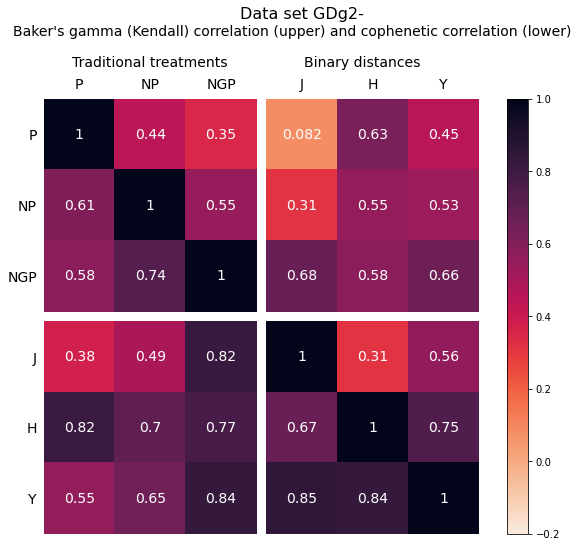

In [51]:
f, ax = plt.subplots(figsize=(10,8))

combineCK(correlations_neg)

pm = plot_partitioned_df_asheatmap(correlations_neg['CK'], ax=ax, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=3, top_rotate=False)
ax.text(3.5, -0.9, "Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)",
        ha='center', fontsize=14)

f.suptitle("Data set GDg2-", fontsize=16, y=1.04)
ax.text(1.5,-0.45, 'Traditional treatments', fontsize=14, ha='center')
ax.text(4.5,-0.45, 'Binary distances', fontsize=14, ha='center')

plt.show()

### Positive GD (1st Filtering/Alignment) with 3 different binary distance metrics - Part of Suppl. Fig. 6.3

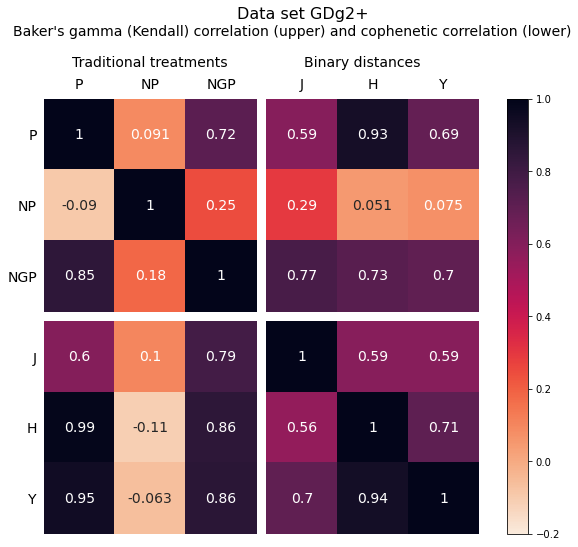

In [52]:
f, ax = plt.subplots(figsize=(10,8))

combineCK(correlations_pos)

pm = plot_partitioned_df_asheatmap(correlations_pos['CK'], ax=ax, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=3, top_rotate=False)
ax.text(3.5, -0.9, "Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)",
        ha='center', fontsize=14)

f.suptitle("Data set GDg2+", fontsize=16, y=1.04)
ax.text(1.5,-0.45, 'Traditional treatments', fontsize=14, ha='center')
ax.text(4.5,-0.45, 'Binary distances', fontsize=14, ha='center')

plt.show()

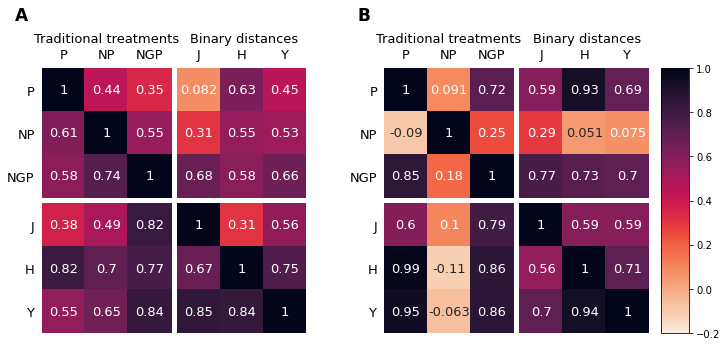

In [53]:
f, (axl, axr) = plt.subplots(1,2, figsize=(10,4.7), constrained_layout=True)

combineCK(correlations_neg)

pm = plot_partitioned_df_asheatmap(correlations_neg['CK'], ax=axl, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True), fontsize=13,
                                    partition_point=3, top_rotate=False, colorbar=False)
#axl.set_title("Data set GDg2-", fontsize=16, y=1.15)
axl.text(1.5,-0.6, 'Traditional treatments', fontsize=13, ha='center')
axl.text(4.7,-0.6, 'Binary distances', fontsize=13, ha='center')

combineCK(correlations_pos)

pm = plot_partitioned_df_asheatmap(correlations_pos['CK'], ax=axr, vmin=-0.2, vmax=1,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True), fontsize=13,
                                    partition_point=3, top_rotate=False)

#axr.set_title("Data set GDg2+", fontsize=16, y=1.15)
axr.text(1.5,-0.6, 'Traditional treatments', fontsize=13, ha='center')
axr.text(4.7,-0.6, 'Binary distances', fontsize=13, ha='center')

for letter, ax in zip('ABCDEFGHIJ', (axl, axr)):
    ax.text(-0.1, 1.2, letter, ha='left', va='center', fontsize=17, weight='bold',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))


f.savefig('paperimages/coph_baker_corrs.pdf', dpi=400)
f.savefig('paperimages/coph_baker_corrs.png', dpi=600)

plt.show()

### Negative and Positive GD (1st Filtering/Alignment) with 9 different binary distance metrics - Example

In [54]:
colnames = ['P -', 'NP -', 'NGP -', 'P +', 'NP +', 'NGP +','dice -', 'hamming -',
            'jaccard -', 'rogerstanimoto -', 'sokalmichener -', 'sokalsneath -','yule -', 
            'kulsinski -', 'russellrao -','dice +', 'hamming +', 'jaccard +', 'rogerstanimoto +', 
            'sokalmichener +', 'sokalsneath +', 'yule +', 'kulsinski +', 'russellrao +']

treatments = colnames

colectedHCAs = {}
for name in treatments:
    tname, mode = name.split()
    if mode == '-':
        colectedHCAs[name] = HCA_all['GD_neg_global2'][tname]
    else:
        colectedHCAs[name] = HCA_all['GD_pos_global2'][tname]

In [55]:
all_correlations = create_HCA_correlations(colectedHCAs, treatments, colnames)

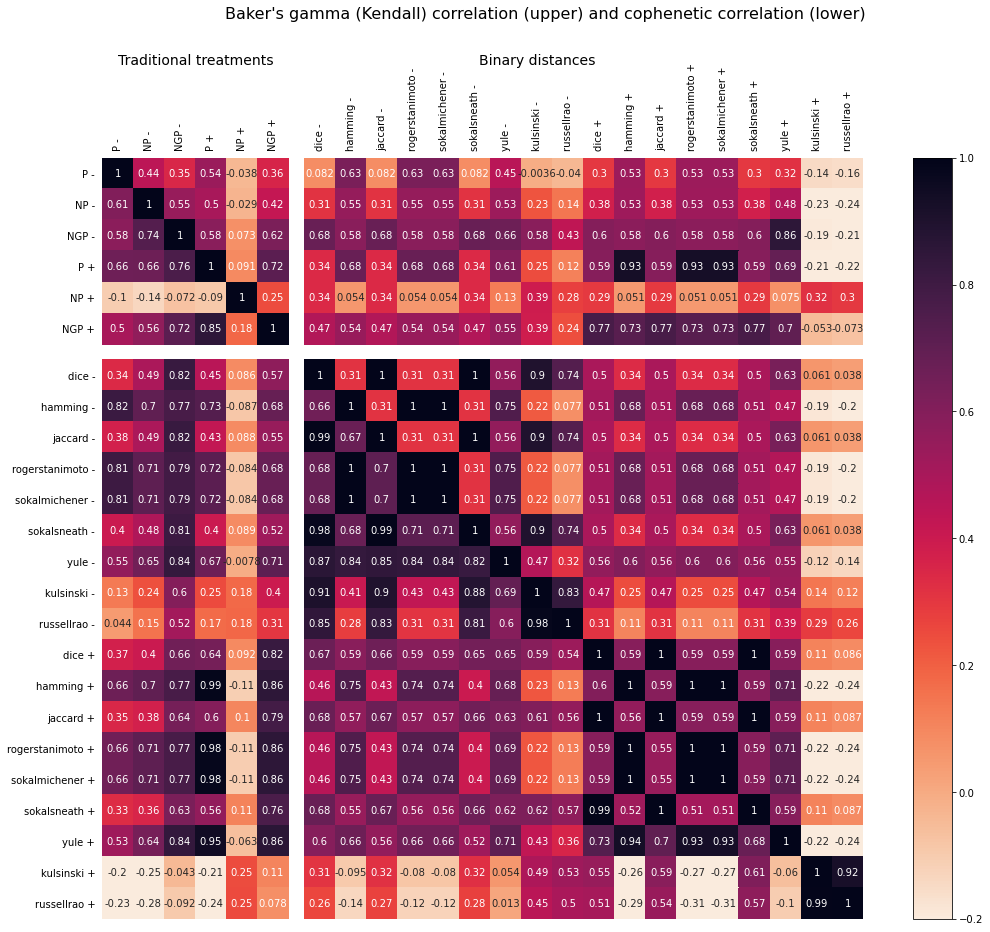

In [56]:
f, ax = plt.subplots(figsize=(18,14))

combineCK(all_correlations)

pm = plot_partitioned_df_asheatmap(all_correlations['CK'], ax=ax, vmin=-0.2, vmax=1, fontsize=10,
                                    cmap=sns.color_palette("rocket_r", as_cmap=True),
                                    partition_point=6, top_rotate=True)

f.suptitle("Baker's gamma (Kendall) correlation (upper) and cophenetic correlation (lower)", fontsize=16, y=1.03)

ax.text(3,-3, 'Traditional treatments', fontsize=14, ha='center')
ax.text(14,-3, 'Binary distances', fontsize=14, ha='center')

plt.show()

### Comparing HCAs (Dendrograms) Discrimination

Only for 1st alignment/filtering - 1-2

Using 3 different metrics explained in the dissertation:

- Discrimination Distance
- Correct Clustering Percentage
- Correct First Cluster

Functions applied here (`dist_discrim` and `correct_1stcluster_fraction`) from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct (Group) Clustering definition - samples of a group all clustered together before any other sample clustered with a sample of said group.

In [57]:
def compute_clustering_metrics(res_dict, labels):
    """Fill dict with clustering performance metrics"""
    discrim = ma.dist_discrim(res_dict['Z'], labels, # all samples have the same order
                              method = 'average')
    res_dict['Average discrim dist'] = discrim[0]
    correct = np.array(list(discrim[1].values()))
    
    classes = pd.unique(labels)
    res_dict['% correct clustering'] = (100/len(classes)) * len(correct[correct>0])

    # Correct First Cluster Percentage
    res_dict['% correct 1st clustering'] = 100 * ma.correct_1stcluster_fraction(res_dict['Z'],labels)
    

In [58]:
# colectedHCAs exists!
for name, res_dict in colectedHCAs.items():
    compute_clustering_metrics(res_dict, parsed.sample_labels)

In [59]:
clust_performance = {}

for metric in ('Average discrim dist', '% correct clustering', '% correct 1st clustering'):
    clust_performance[metric] = {d: colectedHCAs[d][metric] for d in colectedHCAs}
clust_performance = pd.DataFrame(clust_performance, index=colectedHCAs)
clust_performance

,Average discrim dist,% correct clustering,% correct 1st clustering
P -,0.094914,45.454545,63.636364
NP -,0.124395,45.454545,63.636364
NGP -,0.138279,54.545455,78.787879
P +,0.033682,27.272727,33.333333
NP +,0.014673,27.272727,27.272727
NGP +,0.025067,18.181818,48.484848
dice -,0.173747,54.545455,66.666667
hamming -,0.119555,45.454545,69.696970
jaccard -,0.154588,54.545455,66.666667
rogerstanimoto -,0.124665,45.454545,69.696970


In [60]:
clust_performance_pos = clust_performance[clust_performance.index.str.endswith('+')]
clust_performance_neg = clust_performance[clust_performance.index.str.endswith('-')]
#clust_performance_neg

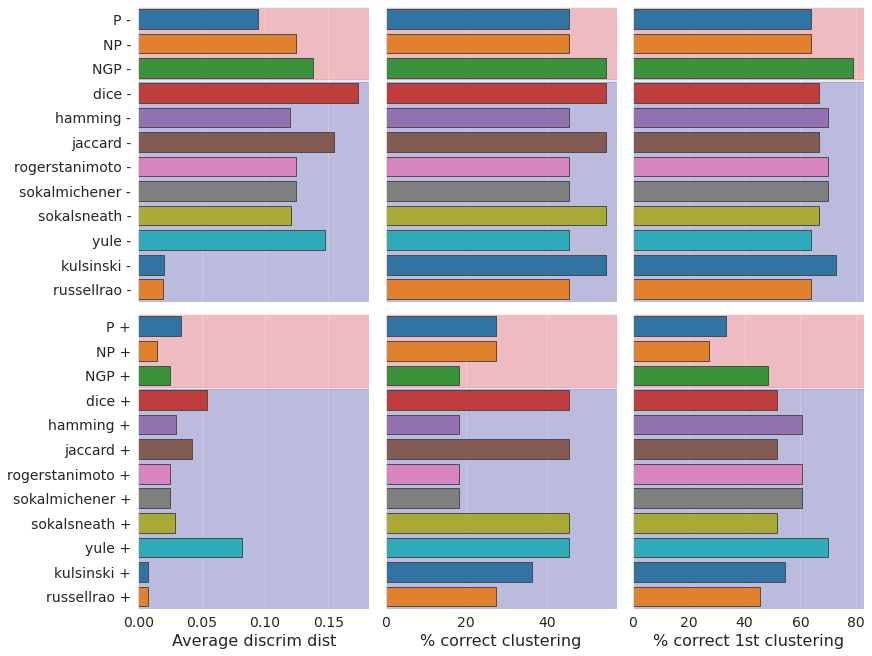

In [61]:
with sns.axes_style("darkgrid"):
    f, axs = plt.subplots(2, 3, figsize=(12, 9), sharey='row', sharex='col', constrained_layout=True)
    for ax in axs.ravel():
        ax.tick_params(labelsize=14)
        ax.xaxis.label.set_size(16)
        ax.axhspan(-0.5, 2.45, color='red', alpha=0.2)
        ax.axhspan(2.55, 11.5, color='darkblue', alpha=0.2)
    sns.barplot(y=clust_performance_neg.index, x=clust_performance_neg['% correct clustering'], ax=axs[0][1], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_neg.index, x=clust_performance_neg['% correct 1st clustering'], ax=axs[0][2], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_neg.index, x=clust_performance_neg['Average discrim dist'], ax=axs[0][0], palette='tab10', ec='0.3')

    sns.barplot(y=clust_performance_pos.index, x=clust_performance_pos['Average discrim dist'], ax=axs[1][0], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_pos.index, x=clust_performance_pos['% correct clustering'], ax=axs[1][1], palette='tab10', ec='0.3')
    sns.barplot(y=clust_performance_pos.index, x=clust_performance_pos['% correct 1st clustering'], ax=axs[1][2], palette='tab10', ec='0.3')

    for ax in axs[0]:
        ax.xaxis.label.set_visible(False)

In [62]:
HCA_performance = []
for name, dataset in datasets.items():
    if name == 'vitis_types':
        continue
    for treatment in ('P', 'NP', 'NGP', 'BinSim'):
        compute_clustering_metrics(HCA_all[name][treatment], datasets[name]['target'])
        perform = {'dataset': name, 'treatment': treatment,
                   'Discrimination Distance': HCA_all[name][treatment]['Average discrim dist'],
                   '% correct clusters': HCA_all[name][treatment]['% correct clustering'],
                   '% correct 1st clustering': HCA_all[name][treatment]['% correct 1st clustering']}
        HCA_performance.append(perform)
        
HCA_performance = pd.DataFrame(HCA_performance)

#cv_dsnames = {'GD_neg_global2': 'global2 -',
              #'GD_pos_global2': 'global2 +',
              #'GD_neg_class2': 'class2 -',
              #'GD_pos_class2': 'class2 +',
              #'YD': 'YD'}
cv_dsnames = {name:datasets[name]['name'] for name in datasets}

HCA_performance2 = HCA_performance.assign(dataset = HCA_performance['dataset'].map(cv_dsnames))
HCA_performance2

,dataset,treatment,Discrimination Distance,% correct clusters,% correct 1st clustering
0,GDg2-,P,0.094914,45.454545,63.636364
1,GDg2-,NP,0.124395,45.454545,63.636364
2,GDg2-,NGP,0.138279,54.545455,78.787879
3,GDg2-,BinSim,0.154588,54.545455,66.666667
4,GDg2+,P,0.033682,27.272727,33.333333
5,GDg2+,NP,0.014673,27.272727,27.272727
6,GDg2+,NGP,0.025067,18.181818,48.484848
7,GDg2+,BinSim,0.042618,45.454545,51.515152
8,GDc2-,P,0.153994,63.636364,81.818182
9,GDc2-,NP,0.164414,72.727273,90.909091


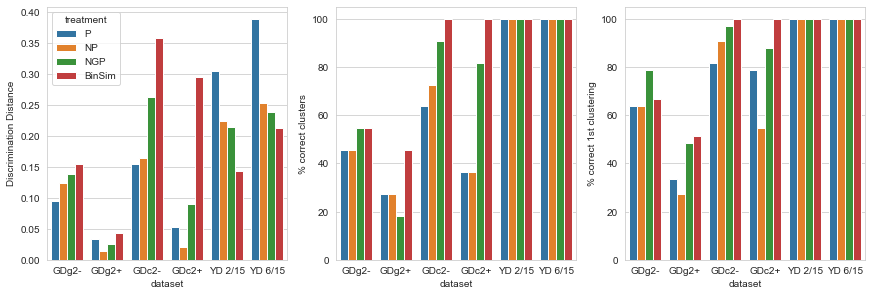

In [63]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance2, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance2, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance2, ax=axs[2], palette=p4)
    axs[1].legend().set_visible(False)
    axs[2].legend().set_visible(False)
    plt.show()

### K-means Clustering Analysis

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

In [64]:
import sklearn.cluster as skclust
from sklearn.metrics import adjusted_rand_score

#### Example of what happens in a K-means clustering analysis and how samples are separated 

Use of the sci-kit learn Python package - sklearn. 

Cluster number equal to the amount of groups. Default parameters except number of clusters.

K-means clustering analysis has an intrinsically random side to it depending on the starting position of the clusters and existence of local minima.

### K-means clustering applied to all euclidean methods and the binary-simplified data sets

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA).

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [65]:
def perform_KMeans(dataset, treatment, iter_num=150, best_fraction=0.1):
    sample_labels = datasets[dataset]['target']
    n_classes = len(pd.unique(sample_labels))
    
    df = datasets[dataset][treatment]
    
    discrim = ma.Kmeans_discrim(df, sample_labels,
                                method='average', 
                                iter_num=iter_num,
                                best_fraction=best_fraction)

    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    
    for j in discrim:
        global_disc_dist, disc_dists, rand_index, SSE = discrim[j]
        
        # Average of discrimination distances
        average.append(global_disc_dist) 
        
        # Correct Clustering Percentages
        all_correct = np.array(list(disc_dists.values()))
        correct.append(len(all_correct[all_correct>0]))
        
        # Adjusted Rand Index
        rand.append(rand_index) 
    
    return{'dataset': dataset,
           'treatment': treatment,
           'Discrimination Distance': np.median(average),
           '% correct clusters':np.median(correct)*100/n_classes,
           'Rand Index': np.median(rand)}

In [66]:
# NOTE: for debugging
iter_num=15
# otherwise
#iter_num=150

KMeans_all = []

for dsname in ('GD_neg_global2', 'GD_pos_global2', 'GD_neg_class2', 'GD_pos_class2', 'YD', 'YD2'):
    for treatment in ('P', 'NP', 'NGP', 'BinSim'):
        print(f'performing KMeans on {dsname} with treatment {treatment}' , end=' ...')
        KMeans_all.append(perform_KMeans(dsname, treatment, iter_num=iter_num))
        print('done!')        

performing KMeans on GD_neg_global2 with treatment P ...done!
performing KMeans on GD_neg_global2 with treatment NP ...done!
performing KMeans on GD_neg_global2 with treatment NGP ...done!
performing KMeans on GD_neg_global2 with treatment BinSim ...done!
performing KMeans on GD_pos_global2 with treatment P ...done!
performing KMeans on GD_pos_global2 with treatment NP ...done!
performing KMeans on GD_pos_global2 with treatment NGP ...done!
performing KMeans on GD_pos_global2 with treatment BinSim ...done!
performing KMeans on GD_neg_class2 with treatment P ...done!
performing KMeans on GD_neg_class2 with treatment NP ...done!
performing KMeans on GD_neg_class2 with treatment NGP ...done!
performing KMeans on GD_neg_class2 with treatment BinSim ...done!
performing KMeans on GD_pos_class2 with treatment P ...done!
performing KMeans on GD_pos_class2 with treatment NP ...done!
performing KMeans on GD_pos_class2 with treatment NGP ...done!
performing KMeans on GD_pos_class2 with treatment 

In [67]:
KMeans_all = pd.DataFrame(KMeans_all)
#cv_dsnames = {'GD_neg_global2': 'global2 -',
              #'GD_pos_global2': 'global2 +',
              #'GD_neg_class2': 'class2 -',
              #'GD_pos_class2': 'class2 +',
              #'YD': 'YD'}
cv_dsnames = {name:datasets[name]['name'] for name in datasets}
KMeans_all2 = KMeans_all.assign(dataset = KMeans_all['dataset'].map(cv_dsnames))

In [68]:
KMeans_all2

,dataset,treatment,Discrimination Distance,% correct clusters,Rand Index
0,GDg2-,P,0.084766,18.181818,0.523277
1,GDg2-,NP,0.128850,27.272727,0.499176
2,GDg2-,NGP,0.149299,31.818182,0.579708
3,GDg2-,BinSim,0.159055,27.272727,0.541060
4,GDg2+,P,0.000000,0.000000,0.215548
5,GDg2+,NP,0.040459,27.272727,0.534465
6,GDg2+,NGP,0.000000,0.000000,0.314607
7,GDg2+,BinSim,0.033078,4.545455,0.213540
8,GDc2-,P,0.170711,36.363636,0.658703
9,GDc2-,NP,0.182214,45.454545,0.703204


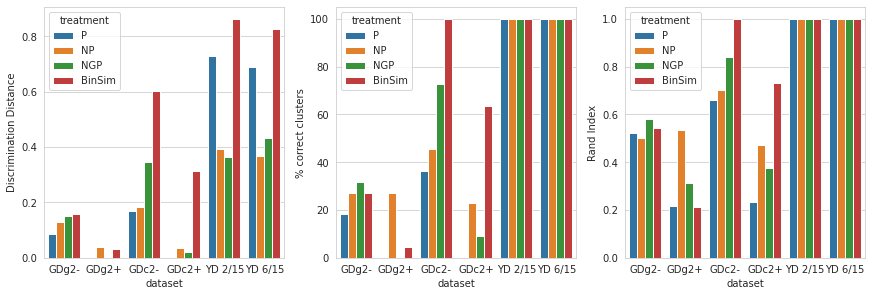

In [69]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    #for ax in axs.ravel():
        #ax.tick_params(labelsize=14)
        #ax.xaxis.label.set_size(16)
        #ax.axhspan(-0.5, 3.5, color='red', alpha=0.2)
        #ax.axhspan(3.55, 7.5, color='darkblue', alpha=0.2)
        #ax.axhspan(7.55, 11.5, color='red', alpha=0.2)
        #ax.axhspan(11.55, 16, color='darkblue', alpha=0.2)
    sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_all2, ax=axs[0], palette=p4)
    sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_all2, ax=axs[1], palette=p4)
    sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_all2, ax=axs[2], palette=p4)
    

#### Summary of clustering performance

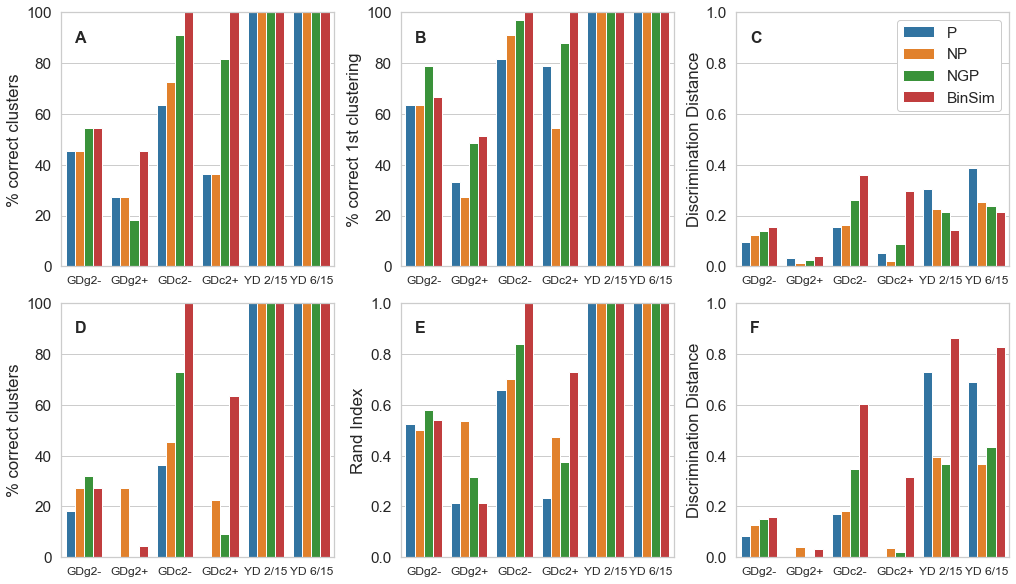

In [73]:
p4 = sns.color_palette('tab10', 4)
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.4):
        f, axs = plt.subplots(2, 3, figsize=(14, 8), constrained_layout=True)
        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=HCA_performance2, ax=axs[0][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=HCA_performance2, ax=axs[0][0], palette=p4)
        sns.barplot(x="dataset", y="% correct 1st clustering", hue="treatment", data=HCA_performance2, ax=axs[0][1], palette=p4)

        sns.barplot(x="dataset", y="Discrimination Distance", hue="treatment", data=KMeans_all2, ax=axs[1][2], palette=p4)
        sns.barplot(x="dataset", y="% correct clusters", hue="treatment", data=KMeans_all2, ax=axs[1][0], palette=p4)
        sns.barplot(x="dataset", y="Rand Index", hue="treatment", data=KMeans_all2, ax=axs[1][1], palette=p4)
        for i, ax in enumerate(axs.ravel()):
            ax.set_ylim(0,100)
            ax.xaxis.label.set_visible(False)
            ax.legend().set_visible(False)
            ax.tick_params(axis='x', which='major', labelsize=12)
        #axs[0][1].set_title('HCA', fontsize=15)
        #axs[1][1].set_title('KMeans', fontsize=15)
        axs[0][2].legend(bbox_to_anchor=(1,1), loc="upper right", framealpha=1)
        axs[1][2].set_ylim(0,1.0)
        axs[0][2].set_ylim(0,1)
        axs[1][1].set_ylim(0,1)
        
        for letter, ax in zip('ABCDEFGHIJ', axs.ravel()):
            ax.text(0.05, 0.9, letter, ha='left', va='center', fontsize=16, weight='bold',
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', edgecolor='white', alpha=0.9))

        plt.show()

        f.savefig('paperimages/clust_performance.pdf' , dpi=200)
        f.savefig('paperimages/clust_performance.png' , dpi=600)
        f.savefig('paperimages/clust_performance.svg')